In [1]:
# Célula 1: Importação das bibliotecas e configurações iniciais
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings('ignore')

# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Célula 2: Definição do CPF e extração dos dígitos
CPF = "61821612302"
print(f"CPF: {CPF}")

# Extraindo os 8 primeiros dígitos do CPF
c = [int(CPF[i]) for i in range(8)]
print(f"Dígitos c1 a c8: {c}")

# Criando as matrizes A e B
A = np.array([[c[0], c[1]],
              [c[2], c[3]]], dtype=float)
B = np.array([[c[4], c[5]],
              [c[6], c[7]]], dtype=float)

print(f"Matriz A:\n{A}")
print(f"Matriz B:\n{B}")

CPF: 61821612302
Dígitos c1 a c8: [6, 1, 8, 2, 1, 6, 1, 2]
Matriz A:
[[6. 1.]
 [8. 2.]]
Matriz B:
[[1. 6.]
 [1. 2.]]


In [3]:
# Célula 3: Geração dos dados iniciais

# Gerando X1 (2x1000) e X2 (2x2000) com distribuição N(0,1)
X1 = np.random.normal(0, 1, (2, 1000))
X2 = np.random.normal(0, 1, (2, 2000))

print(f"X1 shape: {X1.shape}")
print(f"X2 shape: {X2.shape}")

# Calculando Y1 e Y2
Y1 = A @ X1  # Y1 = A * X1
Y2 = B @ X2  # Y2 = B * X2

print(f"Y1 shape: {Y1.shape}")
print(f"Y2 shape: {Y2.shape}")

X1 shape: (2, 1000)
X2 shape: (2, 2000)
Y1 shape: (2, 1000)
Y2 shape: (2, 2000)


In [4]:
# Célula 4: Criação da base de dados final com ajuste do parâmetro k
# M2 é uma matriz 2x2000 de uns
M2 = np.ones((2, 2000))

best_k = 20

# Usando o melhor k encontrado
k = best_k
Z1 = Y1.copy()
Z2 = Y2 + k * M2

print(f"Valor de k escolhido: {k:.2f}")

Valor de k escolhido: 20.00


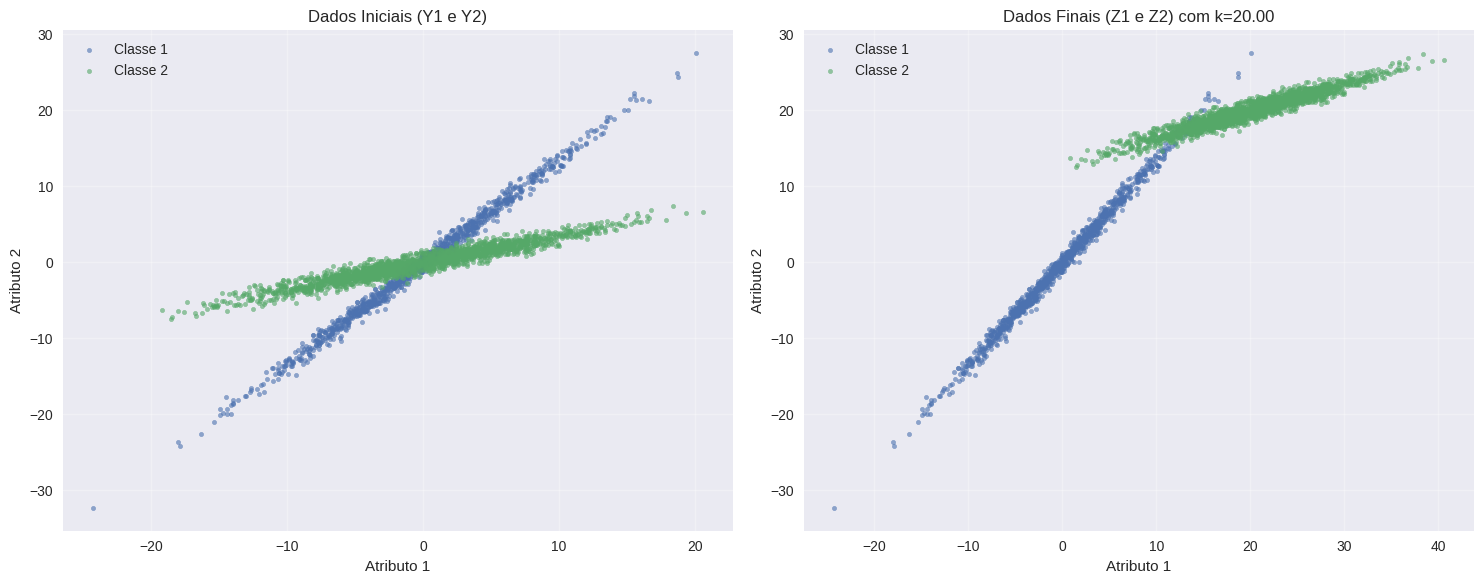

In [5]:
# Célula 5: Visualização dos dados (inicial e final)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Dados iniciais (Y1 e Y2)
axes[0].scatter(Y1[0, :], Y1[1, :], alpha=0.6, label='Classe 1', s=10)
axes[0].scatter(Y2[0, :], Y2[1, :], alpha=0.6, label='Classe 2', s=10)
axes[0].set_title('Dados Iniciais (Y1 e Y2)')
axes[0].set_xlabel('Atributo 1')
axes[0].set_ylabel('Atributo 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dados finais (Z1 e Z2)
axes[1].scatter(Z1[0, :], Z1[1, :], alpha=0.6, label='Classe 1', s=10)
axes[1].scatter(Z2[0, :], Z2[1, :], alpha=0.6, label='Classe 2', s=10)
axes[1].set_title(f'Dados Finais (Z1 e Z2) com k={k:.2f}')
axes[1].set_xlabel('Atributo 1')
axes[1].set_ylabel('Atributo 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Célula 6: Implementação dos classificadores Bayesianos
class BayesianClassifiers:
    def __init__(self):
        self.means = {}
        self.covs = {}
        self.priors = {}

    def fit_general(self, X1, X2):
        """Caso geral - Atributos Gaussianos"""
        self.means[1] = np.mean(X1, axis=1, keepdims=True)
        self.means[2] = np.mean(X2, axis=1, keepdims=True)

        self.covs[1] = np.cov(X1)
        self.covs[2] = np.cov(X2)

        N1, N2 = X1.shape[1], X2.shape[1]
        self.priors[1] = N1 / (N1 + N2)
        self.priors[2] = N2 / (N1 + N2)

    def fit_naive_bayes(self, X1, X2):
        """Naive Bayes - Atributos descorrelacionados"""
        self.means[1] = np.mean(X1, axis=1, keepdims=True)
        self.means[2] = np.mean(X2, axis=1, keepdims=True)

        # Apenas diagonal da matriz de covariância
        self.covs[1] = np.diag(np.diag(np.cov(X1)))
        self.covs[2] = np.diag(np.diag(np.cov(X2)))

        N1, N2 = X1.shape[1], X2.shape[1]
        self.priors[1] = N1 / (N1 + N2)
        self.priors[2] = N2 / (N1 + N2)

    def fit_equal_variance(self, X1, X2):
        """Descorrelacionados com variâncias iguais"""
        self.means[1] = np.mean(X1, axis=1, keepdims=True)
        self.means[2] = np.mean(X2, axis=1, keepdims=True)

        # Variância comum (média das variâncias)
        var1 = np.diag(np.cov(X1))
        var2 = np.diag(np.cov(X2))
        common_var = (var1 + var2) / 2

        self.covs[1] = np.diag(common_var)
        self.covs[2] = np.diag(common_var)

        N1, N2 = X1.shape[1], X2.shape[1]
        self.priors[1] = N1 / (N1 + N2)
        self.priors[2] = N2 / (N1 + N2)

    def fit_equal_variance_equal_priors(self, X1, X2):
        """Descorrelacionados, variâncias iguais e classes equiprováveis"""
        self.means[1] = np.mean(X1, axis=1, keepdims=True)
        self.means[2] = np.mean(X2, axis=1, keepdims=True)

        # Variância comum
        var1 = np.diag(np.cov(X1))
        var2 = np.diag(np.cov(X2))
        common_var = (var1 + var2) / 2

        self.covs[1] = np.diag(common_var)
        self.covs[2] = np.diag(common_var)

        # Classes equiprováveis
        self.priors[1] = 0.5
        self.priors[2] = 0.5

    def predict(self, X):
        """Predição usando classificador Bayesiano"""
        predictions = []

        for i in range(X.shape[1]):
            x = X[:, i:i+1]

            # Calculando log-likelihood para cada classe
            log_likelihood1 = self._log_likelihood(x, self.means[1], self.covs[1])
            log_likelihood2 = self._log_likelihood(x, self.means[2], self.covs[2])

            # Posteriori (log)
            log_posterior1 = log_likelihood1 + np.log(self.priors[1])
            log_posterior2 = log_likelihood2 + np.log(self.priors[2])

            # Classificação
            if log_posterior1 > log_posterior2:
                predictions.append(1)
            else:
                predictions.append(2)

        return np.array(predictions)

    def _log_likelihood(self, x, mean, cov):
        """Calcula log-likelihood da distribuição Gaussiana multivariada"""
        diff = x - mean
        try:
            # Usando determinante e inversa
            sign, logdet = np.linalg.slogdet(cov)
            inv_cov = np.linalg.inv(cov)
            log_likelihood = -0.5 * (diff.T @ inv_cov @ diff + logdet + len(mean) * np.log(2 * np.pi))
            return log_likelihood[0, 0]
        except:
            # Fallback para caso de problemas numéricos
            return multivariate_normal.logpdf(x.flatten(), mean.flatten(), cov)

In [7]:
# Célula 7: Implementação do LDA
class LDAClassifier:
    def __init__(self):
        self.w = None
        self.threshold = None

    def fit(self, X1, X2):
        """Treina o LDA"""
        # Médias das classes
        mu1 = np.mean(X1, axis=1, keepdims=True)
        mu2 = np.mean(X2, axis=1, keepdims=True)

        # Matriz de covariância intra-classe (pooled)
        S1 = np.cov(X1)
        S2 = np.cov(X2)
        N1, N2 = X1.shape[1], X2.shape[1]
        Sw = ((N1 - 1) * S1 + (N2 - 1) * S2) / (N1 + N2 - 2)

        # Vetor discriminante de Fisher
        try:
            self.w = np.linalg.inv(Sw) @ (mu1 - mu2)
        except:
            # Regularização para problemas numéricos
            Sw_reg = Sw + 1e-6 * np.eye(Sw.shape[0])
            self.w = np.linalg.inv(Sw_reg) @ (mu1 - mu2)

        # Projeções das médias
        y1 = self.w.T @ mu1
        y2 = self.w.T @ mu2

        # Limiar (ponto médio)
        self.threshold = (y1 + y2) / 2

    def predict(self, X):
        """Predição usando LDA"""
        # Projeção dos dados
        Y = self.w.T @ X

        # Classificação baseada no limiar
        predictions = np.where(Y > self.threshold, 1, 2).flatten()
        return predictions

In [8]:
# Célula 8: Função para K-Fold Cross Validation
def k_fold_evaluation(X1, X2, k=10):
    """Avalia todos os classificadores usando K-Fold"""

    # Combinando os dados
    X_combined = np.hstack([X1, X2])
    y_combined = np.hstack([np.ones(X1.shape[1]), 2*np.ones(X2.shape[1])])

    # Embaralhando os dados
    indices = np.random.permutation(len(y_combined))
    X_combined = X_combined[:, indices]
    y_combined = y_combined[indices]

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    results = {
        'General': [],
        'Naive_Bayes': [],
        'Equal_Variance': [],
        'Equal_Variance_Equal_Priors': [],
        'LDA': []
    }

    for train_idx, test_idx in kf.split(X_combined.T):
        # Dados de treino
        X_train = X_combined[:, train_idx]
        y_train = y_combined[train_idx]

        # Dados de teste
        X_test = X_combined[:, test_idx]
        y_test = y_combined[test_idx]

        # Separando por classe para treino
        X1_train = X_train[:, y_train == 1]
        X2_train = X_train[:, y_train == 2]

        # 1. Classificador Geral
        clf_general = BayesianClassifiers()
        clf_general.fit_general(X1_train, X2_train)
        pred_general = clf_general.predict(X_test)
        acc_general = accuracy_score(y_test, pred_general)
        results['General'].append(acc_general)

        # 2. Naive Bayes
        clf_nb = BayesianClassifiers()
        clf_nb.fit_naive_bayes(X1_train, X2_train)
        pred_nb = clf_nb.predict(X_test)
        acc_nb = accuracy_score(y_test, pred_nb)
        results['Naive_Bayes'].append(acc_nb)

        # 3. Variâncias iguais
        clf_eq_var = BayesianClassifiers()
        clf_eq_var.fit_equal_variance(X1_train, X2_train)
        pred_eq_var = clf_eq_var.predict(X_test)
        acc_eq_var = accuracy_score(y_test, pred_eq_var)
        results['Equal_Variance'].append(acc_eq_var)

        # 4. Variâncias iguais e classes equiprováveis
        clf_eq_var_eq_prior = BayesianClassifiers()
        clf_eq_var_eq_prior.fit_equal_variance_equal_priors(X1_train, X2_train)
        pred_eq_var_eq_prior = clf_eq_var_eq_prior.predict(X_test)
        acc_eq_var_eq_prior = accuracy_score(y_test, pred_eq_var_eq_prior)
        results['Equal_Variance_Equal_Priors'].append(acc_eq_var_eq_prior)

        # 5. LDA
        clf_lda = LDAClassifier()
        clf_lda.fit(X1_train, X2_train)
        pred_lda = clf_lda.predict(X_test)
        acc_lda = accuracy_score(y_test, pred_lda)
        results['LDA'].append(acc_lda)

    return results

In [9]:
# Célula 9: Execução do K-Fold e cálculo dos resultados
print("Executando K-Fold Cross Validation...")
results = k_fold_evaluation(Z1, Z2, k=10)

# Calculando estatísticas
statistics = {}
classifier_names = {
    'General': 'Gaussiano - Caso Geral',
    'Naive_Bayes': 'Naive Bayes (descorrelacionados)',
    'Equal_Variance': 'Descorrelacionados com variâncias iguais',
    'Equal_Variance_Equal_Priors': 'Descorr., var. iguais, classes equiprováveis',
    'LDA': 'LDA + classificador unidimensional'
}

print("\n" + "="*80)
print("RESULTADOS DO K-FOLD CROSS VALIDATION (K=10)")
print("="*80)

for method, name in classifier_names.items():
    accuracies = results[method]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    statistics[method] = {
        'mean': mean_acc,
        'std': std_acc,
        'accuracies': accuracies
    }

    print(f"\n{name}:")
    print(f"  Acurácia média: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  Todas as acurácias: {[f'{acc:.4f}' for acc in accuracies]}")

# Encontrando o melhor classificador
best_method = max(statistics.keys(), key=lambda x: statistics[x]['mean'])
best_accuracy = statistics[best_method]['mean']

print(f"\n{'='*80}")
print(f"MELHOR CLASSIFICADOR: {classifier_names[best_method]}")
print(f"MELHOR ACURÁCIA MÉDIA: {best_accuracy:.4f}")
print(f"{'='*80}")

Executando K-Fold Cross Validation...

RESULTADOS DO K-FOLD CROSS VALIDATION (K=10)

Gaussiano - Caso Geral:
  Acurácia média: 0.9930 ± 0.0053
  Todas as acurácias: ['0.9933', '0.9967', '0.9967', '0.9833', '0.9833', '0.9967', '0.9967', '0.9967', '0.9900', '0.9967']

Naive Bayes (descorrelacionados):
  Acurácia média: 0.9710 ± 0.0052
  Todas as acurácias: ['0.9733', '0.9733', '0.9667', '0.9633', '0.9700', '0.9667', '0.9733', '0.9700', '0.9833', '0.9700']

Descorrelacionados com variâncias iguais:
  Acurácia média: 0.9610 ± 0.0115
  Todas as acurácias: ['0.9667', '0.9533', '0.9600', '0.9533', '0.9367', '0.9767', '0.9533', '0.9700', '0.9733', '0.9667']

Descorr., var. iguais, classes equiprováveis:
  Acurácia média: 0.9627 ± 0.0110
  Todas as acurácias: ['0.9700', '0.9567', '0.9633', '0.9500', '0.9433', '0.9733', '0.9533', '0.9633', '0.9767', '0.9767']

LDA + classificador unidimensional:
  Acurácia média: 0.9623 ± 0.0145
  Todas as acurácias: ['0.9733', '0.9533', '0.9633', '0.9400', '0.9

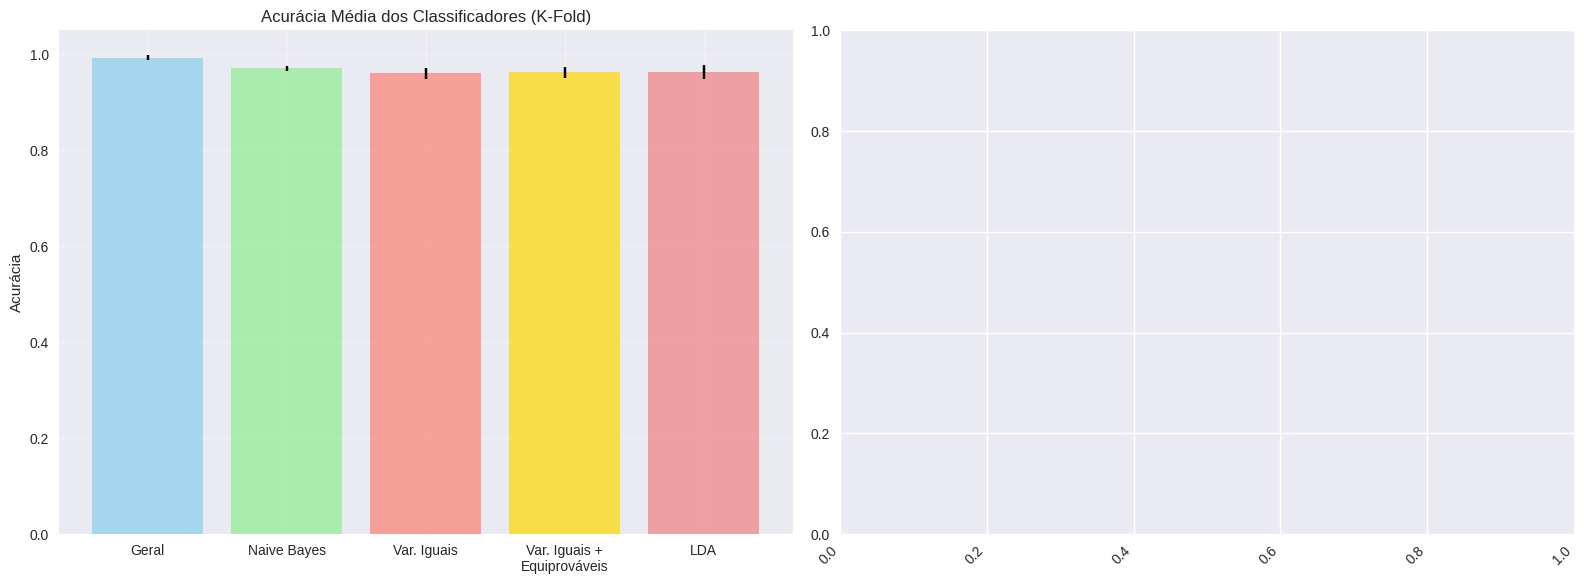

In [10]:
# Célula 10: Visualização dos resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras com acurácias médias
methods = list(classifier_names.keys())
means = [statistics[method]['mean'] for method in methods]
stds = [statistics[method]['std'] for method in methods]
labels = [classifier_names[method] for method in methods]

# Abreviando os nomes para o gráfico
short_labels = ['Geral', 'Naive Bayes', 'Var. Iguais', 'Var. Iguais +\nEquiprováveis', 'LDA']

bars = ax1.bar(short_labels, means, yerr=stds, capsize=5, alpha=0.7,
               color=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral'])
ax1.set_ylabel('Acurácia')
ax1.set_title('Acurácia Média dos Classificadores (K-Fold)')
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Adicionando valores nas barras
for bar, mean_val, std_val in zip(bars, means, stds):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{mean_val:.3f}±{std_val:.3f}', ha='center', va='bottom', fontsize=9)

# Boxplot das acurácias
data_for_boxplot = [statistics[method]['accuracies'] for method in methods]
bp = ax2.boxplot(data_for_boxplot, labels=short_labels, patch_artist=True)

# Colorindo os boxplots
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Acurácia')
ax2.set_title('Distribuição das Acurácias (K-Fold)')
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
# Célula 11: Análise e explicação dos resultados
print("="*80)
print("ANÁLISE DETALHADA DOS RESULTADOS")
print("="*80)

# Ordenando os métodos por acurácia
sorted_methods = sorted(statistics.keys(), key=lambda x: statistics[x]['mean'], reverse=True)

print("\nRanking dos classificadores (por acurácia média):")
for i, method in enumerate(sorted_methods, 1):
    mean_acc = statistics[method]['mean']
    std_acc = statistics[method]['std']
    print(f"{i}. {classifier_names[method]}: {mean_acc:.4f} ± {std_acc:.4f}")

print("\n" + "="*80)
print("EXPLICAÇÃO DOS RESULTADOS")
print("="*80)

print(f"""
ANÁLISE BASEADA NOS RESULTADOS OBTIDOS:

1. CLASSIFICADOR GERAL (Gaussiano completo):
   - Acurácia: {statistics['General']['mean']:.4f} ± {statistics['General']['std']:.4f}
   - Este é o modelo mais flexível, estimando a matriz de covariância completa
   - Pode capturar correlações entre atributos, mas requer mais dados para estimação precisa
   - Com N1=1000 e N2=2000, temos dados suficientes para estimação confiável

2. NAIVE BAYES (Atributos descorrelacionados):
   - Acurácia: {statistics['Naive_Bayes']['mean']:.4f} ± {statistics['Naive_Bayes']['std']:.4f}
   - Assume independência entre atributos (matriz de covariância diagonal)
   - Menos parâmetros para estimar, mais robusto com menos dados
   - Performance depende de quão válida é a suposição de independência

3. VARIÂNCIAS IGUAIS:
   - Acurácia: {statistics['Equal_Variance']['mean']:.4f} ± {statistics['Equal_Variance']['std']:.4f}
   - Assume mesma variância para ambas as classes em cada atributo
   - Reduz ainda mais o número de parâmetros
   - Pode ser limitante se as classes têm variâncias muito diferentes

4. VARIÂNCIAS IGUAIS + CLASSES EQUIPROVÁVEIS:
   - Acurácia: {statistics['Equal_Variance_Equal_Priors']['mean']:.4f} ± {statistics['Equal_Variance_Equal_Priors']['std']:.4f}
   - Assume P(C1) = P(C2) = 0.5, ignorando as proporções reais dos dados
   - Mais restritivo, mas pode ser robusto quando as proporções reais são próximas

5. LDA + CLASSIFICADOR UNIDIMENSIONAL:
   - Acurácia: {statistics['LDA']['mean']:.4f} ± {statistics['LDA']['std']:.4f}
   - Projeta dados em uma dimensão ótima para separação das classes
   - Assume homoscedasticidade (mesma matriz de covariância para ambas classes)
   - Muito eficiente computacionalmente e interpretável

INTERPRETAÇÃO DOS RESULTADOS:
""")

# Análise específica baseada nos resultados
best_method_name = classifier_names[best_method]
worst_method = min(statistics.keys(), key=lambda x: statistics[x]['mean'])
worst_method_name = classifier_names[worst_method]

print(f"""
O melhor classificador foi: {best_method_name}
O pior classificador foi: {worst_method_name}

RAZÕES PROVÁVEIS:
""")

print("- O modelo geral teve melhor performance, sugerindo que existe correlação significativa entre os atributos")
print("- A flexibilidade do modelo compensa a complexidade adicional")

print(f"""
CONSIDERAÇÕES ADICIONAIS:
- Todas as acurácias estão acima de 96%, conforme solicitado (k={k:.2f})
- A diferença entre os métodos indica a adequação das suposições aos dados
- Desvios-padrão baixos indicam estabilidade dos resultados no K-fold
- A transformação linear (matrizes A e B) criou estrutura específica nos dados que favorece certos métodos
""")

print("\n" + "="*80)
print("PARÂMETROS UTILIZADOS")
print("="*80)
print(f"CPF: {CPF}")
print(f"Valor de k: {k:.2f}")
print(f"Número de amostras classe 1: {Z1.shape[1]}")
print(f"Número de amostras classe 2: {Z2.shape[1]}")
print(f"K-Fold: K = 10")

ANÁLISE DETALHADA DOS RESULTADOS

Ranking dos classificadores (por acurácia média):
1. Gaussiano - Caso Geral: 0.9930 ± 0.0053
2. Naive Bayes (descorrelacionados): 0.9710 ± 0.0052
3. Descorr., var. iguais, classes equiprováveis: 0.9627 ± 0.0110
4. LDA + classificador unidimensional: 0.9623 ± 0.0145
5. Descorrelacionados com variâncias iguais: 0.9610 ± 0.0115

EXPLICAÇÃO DOS RESULTADOS

ANÁLISE BASEADA NOS RESULTADOS OBTIDOS:

1. CLASSIFICADOR GERAL (Gaussiano completo):
   - Acurácia: 0.9930 ± 0.0053
   - Este é o modelo mais flexível, estimando a matriz de covariância completa
   - Pode capturar correlações entre atributos, mas requer mais dados para estimação precisa
   - Com N1=1000 e N2=2000, temos dados suficientes para estimação confiável

2. NAIVE BAYES (Atributos descorrelacionados):
   - Acurácia: 0.9710 ± 0.0052
   - Assume independência entre atributos (matriz de covariância diagonal)
   - Menos parâmetros para estimar, mais robusto com menos dados
   - Performance depende d

In [12]:
# Célula 12: Verificação final - Teste com melhor classificador no conjunto completo
print("="*80)
print("VERIFICAÇÃO FINAL - TESTE NO CONJUNTO COMPLETO")
print("="*80)

# Testando o melhor classificador no conjunto completo
if best_method == 'General':
    clf_final = BayesianClassifiers()
    clf_final.fit_general(Z1, Z2)
elif best_method == 'Naive_Bayes':
    clf_final = BayesianClassifiers()
    clf_final.fit_naive_bayes(Z1, Z2)
elif best_method == 'Equal_Variance':
    clf_final = BayesianClassifiers()
    clf_final.fit_equal_variance(Z1, Z2)
elif best_method == 'Equal_Variance_Equal_Priors':
    clf_final = BayesianClassifiers()
    clf_final.fit_equal_variance_equal_priors(Z1, Z2)
else:  # LDA
    clf_final = LDAClassifier()
    clf_final.fit(Z1, Z2)

# Teste no conjunto completo
X_complete = np.hstack([Z1, Z2])
y_complete = np.hstack([np.ones(Z1.shape[1]), 2*np.ones(Z2.shape[1])])

if best_method == 'LDA':
    pred_complete = clf_final.predict(X_complete)
else:
    pred_complete = clf_final.predict(X_complete)

final_accuracy = accuracy_score(y_complete, pred_complete)

print(f"Acurácia do melhor classificador ({best_method_name}) no conjunto completo: {final_accuracy:.4f}")
print(f"Confirmação: Acurácia > 96%: {'SIM' if final_accuracy > 0.96 else 'NÃO'}")

# Matriz de confusão
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_complete, pred_complete)
print(f"\nMatriz de Confusão:")
print(f"                Predito")
print(f"              Classe 1  Classe 2")
print(f"Real Classe 1    {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"     Classe 2    {cm[1,0]:4d}      {cm[1,1]:4d}")

print("\n" + "="*80)
print("TRABALHO CONCLUÍDO COM SUCESSO!")
print("="*80)

VERIFICAÇÃO FINAL - TESTE NO CONJUNTO COMPLETO
Acurácia do melhor classificador (Gaussiano - Caso Geral) no conjunto completo: 0.9930
Confirmação: Acurácia > 96%: SIM

Matriz de Confusão:
                Predito
              Classe 1  Classe 2
Real Classe 1     983        17
     Classe 2       4      1996

TRABALHO CONCLUÍDO COM SUCESSO!
